In [9]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
import mne

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARTICIPANTS_CSV = os.path.join(BASE_DIR, "participants.csv")
MOCA_THRESHOLD = 26

# ROI pairs for connectivity analysis (multi-channel ROIs)
ROI_PAIRS = {
    "theta": [ (["T8","FT8","TP8","FT10","TP10"], ["F5","AF3","F7","F3"]), (["T8","FT8","TP8","FT10","TP10"], ["F4","F6","AF4","F8"]) ],
    "alpha": [ (["O2"], ["F5","AF3","F7","F3"]), (["O1"], ["F4","F6","AF4","F8"]) ]
}

# -------------------------------
# Utilities
# -------------------------------
def get_channel_indices(subj, roi):
    """Return indices of all channels in ROI for the given subject"""
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    if not os.path.exists(epo_file):
        raise FileNotFoundError(f"{subj}: epochs file missing ({epo_file})")
    epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
    ch_names = [c.upper() for c in epochs.ch_names]
    idx = []
    for ch in roi:
        if ch.upper() in ch_names:
            idx.append(ch_names.index(ch.upper()))
    return idx

def load_pli_roi(subjects, band, roi1, roi2):
    """
    Compute mean PLI between two ROIs for each subject.
    ROI = list of channel names.
    """
    pli_map = {}
    for subj in subjects:
        pli_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
        if not os.path.exists(pli_path):
            continue
        mat = np.load(pli_path)
        # symmetrize if triangular
        if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
            mat = mat + mat.T
        if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
            continue

        idx1 = get_channel_indices(subj, roi1)
        idx2 = get_channel_indices(subj, roi2)
        if len(idx1) == 0 or len(idx2) == 0:
            continue

        # Extract PLI for all channel pairs ROI1 x ROI2
        vals = []
        for i in idx1:
            for j in idx2:
                v = mat[i, j] if np.isfinite(mat[i, j]) and mat[i, j] != 0 else mat[j, i]
                if np.isfinite(v):
                    vals.append(v)
        if len(vals) == 0:
            continue

        pli_map[subj] = np.mean(vals)  # mean PLI across ROI pairs
    return pli_map

# -------------------------------
# Load participants and PD MoCA
# -------------------------------
if not os.path.exists(PARTICIPANTS_CSV):
    raise FileNotFoundError(f"participants CSV not found at {PARTICIPANTS_CSV}")

df = pd.read_csv(PARTICIPANTS_CSV, dtype={"participant_id": str})
df.set_index("participant_id", inplace=True)
pd_df = df[df["GROUP"].str.upper() == "PD"].copy()
pd_subjects = pd_df.index.tolist()

# -------------------------------
# Loop over all bands and ROI pairs
# -------------------------------
all_results = []

for band, roi_pairs in ROI_PAIRS.items():
    for roi1, roi2 in roi_pairs:
        pli_map = load_pli_roi(pd_subjects, band=band, roi1=roi1, roi2=roi2)
        if len(pli_map) == 0:
            print(f"No valid PLI for {band} {roi1}-{roi2}")
            continue

        rows = []
        for subj, pli_val in pli_map.items():
            try:
                moca = pd_df.at[subj, "MOCA"]
            except KeyError:
                continue
            if pd.isna(moca):
                continue
            rows.append((subj, float(moca), pli_val))
        if len(rows) == 0:
            continue

        rows_df = pd.DataFrame(rows, columns=["subj", "MOCA", "PLI"]).set_index("subj")
        impaired_df = rows_df[rows_df["MOCA"] < MOCA_THRESHOLD]
        unimpaired_df = rows_df[rows_df["MOCA"] >= MOCA_THRESHOLD]

        # Group stats
        t_stat, p_group = (np.nan, np.nan)
        if len(impaired_df) >= 3 and len(unimpaired_df) >= 3 and impaired_df["PLI"].std() > 0 and unimpaired_df["PLI"].std() > 0:
            t_stat, p_group = ttest_ind(impaired_df["PLI"].values, unimpaired_df["PLI"].values, equal_var=False)

        # Pearson correlation
        r, p_corr = (np.nan, np.nan)
        if len(rows_df) >= 4:
            r, p_corr = pearsonr(rows_df["PLI"].values, rows_df["MOCA"].values)

        all_results.append({
            "band": band,
            "roi_pair": f"{'+'.join(roi1)} -> {'+'.join(roi2)}",
            "n_total": len(rows_df),
            "n_impaired": len(impaired_df),
            "n_unimpaired": len(unimpaired_df),
            "t_stat": t_stat,
            "p_group": p_group,
            "pearson_r": r,
            "p_corr": p_corr,
            "impaired_mean": impaired_df["PLI"].mean() if len(impaired_df)>0 else np.nan,
            "unimpaired_mean": unimpaired_df["PLI"].mean() if len(unimpaired_df)>0 else np.nan
        })

# -------------------------------
# Save results
# -------------------------------
df_all = pd.DataFrame(all_results).sort_values(["band", "roi_pair"])
OUT_CSV = os.path.join(BASE_DIR, "PD_PLI_MOCA_all_ROI_pairs.csv")
df_all.to_csv(OUT_CSV, index=False)
print(f"Saved summary to {OUT_CSV}")
print(df_all)


C:\Users\User\AppData\Local\Temp\ipykernel_22040\4191591016.py:28: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_22040\4191591016.py:28: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_22040\4191591016.py:28: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  

Saved summary to C:\Users\User\Documents\EEG_Project\rEEG\PD_PLI_MOCA_all_ROI_pairs.csv
    band                              roi_pair  n_total  n_impaired  \
3  alpha                    O1 -> F4+F6+AF4+F8      100          53   
2  alpha                    O2 -> F5+AF3+F7+F3      100          53   
1  theta  T8+FT8+TP8+FT10+TP10 -> F4+F6+AF4+F8      100          53   
0  theta  T8+FT8+TP8+FT10+TP10 -> F5+AF3+F7+F3      100          53   

   n_unimpaired    t_stat   p_group  pearson_r    p_corr  impaired_mean  \
3            47 -0.582495  0.561649   0.117901  0.242699       0.133062   
2            47  0.424093  0.672499   0.052580  0.603380       0.144250   
1            47 -1.504453  0.135748   0.108947  0.280593       0.129175   
0            47 -1.593160  0.114370   0.153766  0.126655       0.125209   

   unimpaired_mean  
3         0.139505  
2         0.138849  
1         0.145263  
0         0.138830  


C:\Users\User\AppData\Local\Temp\ipykernel_22040\4191591016.py:28: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-099\epo_099_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_22040\4191591016.py:28: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-100\epo_100_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_22040\4191591016.py:28: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-100\epo_100_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  

In [4]:
import os
import numpy as np
import pandas as pd

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARTICIPANTS_CSV = os.path.join(BASE_DIR, r"C:\Users\User\Documents\EEG_Project\rEEG\participants.csv")
MOCA_THRESHOLD = 26

# Define ROIs (example channels)
FRONTAL_LEFT = ['F5', 'AF3', 'F7', 'F3']
FRONTAL_RIGHT = ['F4', 'F6', 'AF4', 'F8']
TEMPORAL_LEFT = ['T7', 'FT7', 'TP7']
TEMPORAL_RIGHT = ['T8', 'FT8', 'TP8']
OCCIPITAL_LEFT = ['O1']
OCCIPITAL_RIGHT = ['O2']

# -------------------------------
# Utilities
# -------------------------------
def load_matrix(subj, band):
    """Load PLI or coherence matrix for a subject/band"""
    path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{band}_pli_matrix.npy")
    if not os.path.exists(path):
        return None
    mat = np.load(path)
    if np.allclose(mat, np.tril(mat)) or np.allclose(mat, np.triu(mat)):
        mat = mat + mat.T
    if mat.ndim != 2 or mat.shape[0] != mat.shape[1]:
        return None
    return mat

def get_indices(subj, channels):
    """Return indices of requested channels in epochs"""
    from mne import read_epochs
    epo_file = os.path.join(BASE_DIR, subj, f"epo_{subj[-3:]}_raw.fif")
    epochs = read_epochs(epo_file, preload=False, verbose=False)
    ch_names = [c.upper() for c in epochs.ch_names]
    return [ch_names.index(c.upper()) for c in channels if c.upper() in ch_names]

def mean_connectivity(mat, idx1, idx2):
    """Compute mean connectivity between two channel sets"""
    if len(idx1) == 0 or len(idx2) == 0:
        return np.nan
    vals = mat[np.ix_(idx1, idx2)]
    return np.nanmean(vals)

# -------------------------------
# Load participants
# -------------------------------
df = pd.read_csv(PARTICIPANTS_CSV, dtype={"participant_id": str})
df.set_index("participant_id", inplace=True)
pd_df = df[df["GROUP"].str.upper() == "PD"]
pd_subjects = pd_df.index.tolist()

# -------------------------------
# Compute features per subject
# -------------------------------
features = []

for subj in pd_subjects:
    row = {"subject": subj}
    # Load matrices
    theta_mat = load_matrix(subj, "theta")
    alpha_mat = load_matrix(subj, "alpha")
    if theta_mat is None or alpha_mat is None:
        continue

    # Get channel indices
    f_left_idx = get_indices(subj, FRONTAL_LEFT)
    f_right_idx = get_indices(subj, FRONTAL_RIGHT)
    t_left_idx = get_indices(subj, TEMPORAL_LEFT)
    t_right_idx = get_indices(subj, TEMPORAL_RIGHT)
    o_left_idx = get_indices(subj, OCCIPITAL_LEFT)
    o_right_idx = get_indices(subj, OCCIPITAL_RIGHT)

    # --- Theta frontal-temporal mean ---
    theta_ft_left = mean_connectivity(theta_mat, f_left_idx, t_left_idx)
    theta_ft_right = mean_connectivity(theta_mat, f_right_idx, t_right_idx)

    row["theta_ft_left"] = theta_ft_left
    row["theta_ft_right"] = theta_ft_right
    row["theta_ft_mean"] = np.nanmean([theta_ft_left, theta_ft_right])


    # --- Occipital-frontal alpha mean ---
    alpha_of_left = mean_connectivity(alpha_mat, o_left_idx, f_left_idx)
    alpha_of_right = mean_connectivity(alpha_mat, o_right_idx, f_right_idx)
    row["alpha_of_mean"] = np.nanmean([alpha_of_left, alpha_of_right])

    # --- Theta asymmetry index ---
    theta_mean = np.nanmean([theta_ft_left, theta_ft_right])
    row["theta_asymmetry_idx"] = (theta_ft_right - theta_ft_left) / (theta_mean + 1e-12)

    # --- Alpha asymmetry index ---
    alpha_mean = np.nanmean([alpha_of_left, alpha_of_right])
    row["alpha_asymmetry_idx"] = (alpha_of_right - alpha_of_left) / (alpha_mean + 1e-12)

    # --- Frontal/posterior ratio ---
    # Frontal: mean connectivity across all frontal pairs (theta + alpha)
    frontal_idx = f_left_idx + f_right_idx
    posterior_idx = t_left_idx + t_right_idx + o_left_idx + o_right_idx
    frontal_vals = np.nanmean(theta_mat[np.ix_(frontal_idx, frontal_idx)])
    posterior_vals = np.nanmean(theta_mat[np.ix_(posterior_idx, posterior_idx)])
    row["frontal_posterior_ratio"] = frontal_vals / (posterior_vals + 1e-12)

    # --- Theta coherence ratio: frontal-temporal / occipital-frontal ---
    theta_ft_mean = row["theta_ft_mean"]
    alpha_of_mean = row["alpha_of_mean"]
    row["theta_coherence_ratio"] = theta_ft_mean / (alpha_of_mean + 1e-12)

    # Add MoCA
    row["MOCA"] = pd_df.at[subj, "MOCA"]
    row["impaired"] = row["MOCA"] < MOCA_THRESHOLD

    features.append(row)

# -------------------------------
# Save results
# -------------------------------
df_features = pd.DataFrame(features)
OUT_CSV = os.path.join(BASE_DIR, "PD_connectivity_features.csv")
df_features.to_csv(OUT_CSV, index=False)
print(f"Saved features to {OUT_CSV}")
print(df_features.head())


C:\Users\User\AppData\Local\Temp\ipykernel_40720\2852252.py:39: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40720\2852252.py:39: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = read_epochs(epo_file, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_40720\2852252.py:39: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = read_epo

Saved features to C:\Users\User\Documents\EEG_Project\rEEG\PD_connectivity_features.csv
   subject  theta_ft_left  theta_ft_right  theta_ft_mean  alpha_of_mean  \
0  sub-001       0.132576        0.104978       0.118777       0.179221   
1  sub-002       0.237011        0.159401       0.198206       0.069059   
2  sub-003       0.097083        0.103333       0.100208       0.088800   
3  sub-004       0.144151        0.093189       0.118670       0.077596   
4  sub-005       0.086691        0.084022       0.085356       0.088120   

   theta_asymmetry_idx  alpha_asymmetry_idx  frontal_posterior_ratio  \
0            -0.232346            -0.003623                 0.926573   
1            -0.391565             0.194413                 0.687161   
2             0.062370             0.090090                 1.459272   
3            -0.429440             0.255266                 1.050681   
4            -0.031266             0.011723                 0.912162   

   theta_coherence_ratio  MO

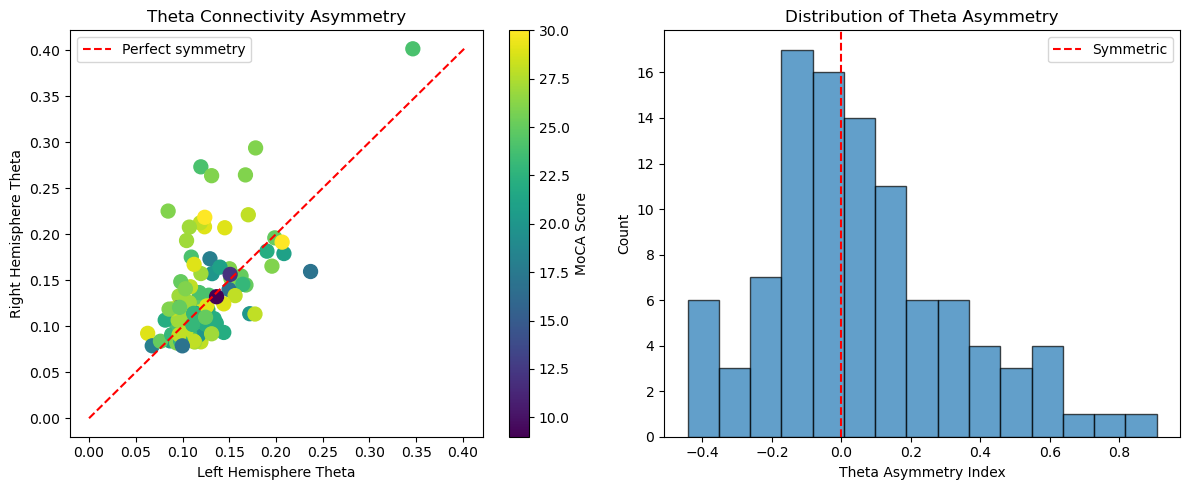

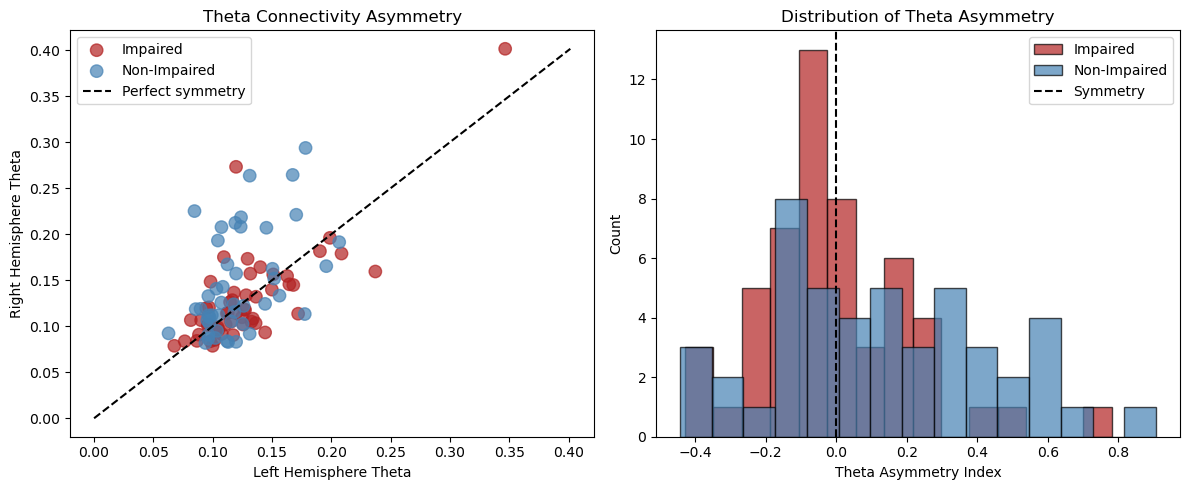

In [18]:
import matplotlib.pyplot as plt
# Compare left vs right hemisphere connectivity
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Theta asymmetry
ax[0].scatter(df['theta_ft_left'], df['theta_ft_right'], 
             c=df['MOCA'], cmap='viridis', s=100)
ax[0].plot([0, df[['theta_ft_left', 'theta_ft_right']].max().max()], 
          [0, df[['theta_ft_left', 'theta_ft_right']].max().max()], 
          'r--', label='Perfect symmetry')
ax[0].set_xlabel('Left Hemisphere Theta')
ax[0].set_ylabel('Right Hemisphere Theta')
ax[0].set_title('Theta Connectivity Asymmetry')
ax[0].legend()

# Color bar
plt.colorbar(ax[0].collections[0], ax=ax[0], label='MoCA Score')

# Alpha asymmetry (similar for alpha_of_left/right if you add them)
ax[1].hist(df['theta_asymmetry_idx'], bins=15, alpha=0.7, edgecolor='black')
ax[1].axvline(0, color='red', linestyle='--', label='Symmetric')
ax[1].set_xlabel('Theta Asymmetry Index')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of Theta Asymmetry')
ax[1].legend()

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Left vs Right scatter, color by group
colors = df['impaired'].map({True: 'firebrick', False: 'steelblue'})
labels = {True: 'Impaired', False: 'Non-Impaired'}

for g in [True, False]:
    mask = df['impaired'] == g
    ax[0].scatter(df.loc[mask, 'theta_ft_left'], df.loc[mask, 'theta_ft_right'],
                  c=colors[mask], label=labels[g], s=80, alpha=0.7)

# Symmetry line
max_val = df[['theta_ft_left', 'theta_ft_right']].max().max()
ax[0].plot([0, max_val], [0, max_val], 'k--', label='Perfect symmetry')

ax[0].set_xlabel('Left Hemisphere Theta')
ax[0].set_ylabel('Right Hemisphere Theta')
ax[0].set_title('Theta Connectivity Asymmetry')
ax[0].legend()

# Panel 2: Histogram of theta asymmetry index by group
bins = 15
ax[1].hist(df.loc[df['impaired']==True, 'theta_asymmetry_idx'], bins=bins,
           alpha=0.7, color='firebrick', label='Impaired', edgecolor='black')
ax[1].hist(df.loc[df['impaired']==False, 'theta_asymmetry_idx'], bins=bins,
           alpha=0.7, color='steelblue', label='Non-Impaired', edgecolor='black')

ax[1].axvline(0, color='k', linestyle='--', label='Symmetry')
ax[1].set_xlabel('Theta Asymmetry Index')
ax[1].set_ylabel('Count')
ax[1].set_title('Distribution of Theta Asymmetry')
ax[1].legend()

plt.tight_layout()
plt.show()


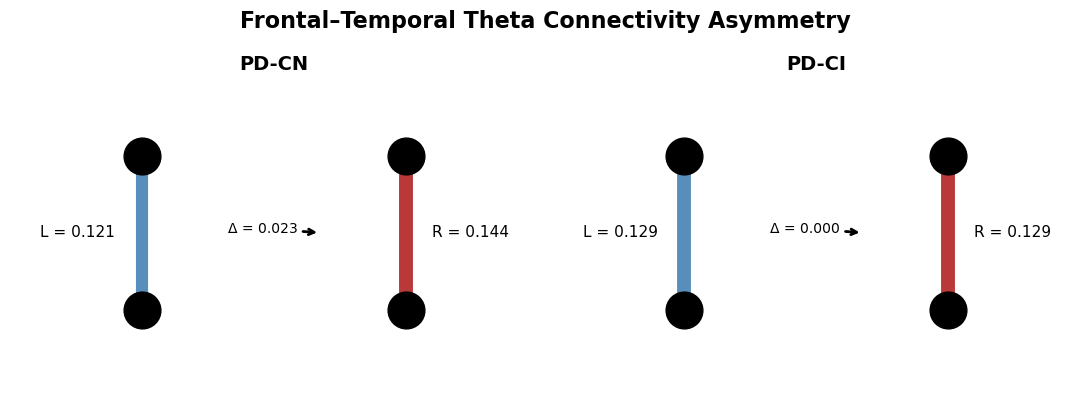

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_lateralized_theta(df, impaired_label, ax):
    sub = df[df["impaired"] == impaired_label]

    L = sub["theta_ft_left"].mean()
    R = sub["theta_ft_right"].mean()

    # --- Normalize for visualization ONLY ---
    max_val = max(L, R)
    Lw = 2 + 8 * (L / max_val)   # linewidth in [2, 10]
    Rw = 2 + 8 * (R / max_val)

    # Node positions
    nodes = {
        "FL": (-1,  0.6),
        "TL": (-1, -0.6),
        "FR": ( 1,  0.6),
        "TR": ( 1, -0.6),
    }

    # Draw nodes
    for x, y in nodes.values():
        ax.scatter(x, y, s=700, color="black", zorder=3)

    # Draw edges (NOW VISIBLE)
    ax.plot([-1, -1], [0.6, -0.6],
            linewidth=Lw, color="steelblue", alpha=0.9)
    ax.plot([ 1,  1], [0.6, -0.6],
            linewidth=Rw, color="firebrick", alpha=0.9)

    # Numeric annotations (critical)
    ax.text(-1.2, 0, f"L = {L:.3f}", ha="right", va="center", fontsize=11)
    ax.text( 1.2, 0, f"R = {R:.3f}", ha="left",  va="center", fontsize=11)

    # Asymmetry arrow
    ax.annotate(
        f"Δ = {R - L:.3f}",
        xy=(0.35, 0), xytext=(-0.35, 0),
        arrowprops=dict(arrowstyle="->", lw=2)
    )

    ax.set_title("PD-CI" if impaired_label else "PD-CN",
                 fontsize=14, weight="bold")

    ax.set_xlim(-2, 2)
    ax.set_ylim(-1.2, 1.2)
    ax.axis("off")

# ---- Plot ----
fig, axes = plt.subplots(1, 2, figsize=(11, 4))
plot_lateralized_theta(df_features, 0, axes[0])
plot_lateralized_theta(df_features, 1, axes[1])

fig.suptitle("Frontal–Temporal Theta Connectivity Asymmetry",
             fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
import numpy as np

# -------------------------------
# Load feature table
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
FEATURE_CSV = f"{BASE_DIR}/PD_connectivity_features.csv"

df = pd.read_csv(FEATURE_CSV)
MOCA_THRESHOLD = 26

# Features to test
FEATURES = [
    "theta_ft_mean",
    "alpha_of_mean",
    "theta_asymmetry_idx",
    "alpha_asymmetry_idx",
    "frontal_posterior_ratio",
    "theta_coherence_ratio"
]

# Split impaired/unimpaired
impaired_df = df[df["impaired"]]
unimpaired_df = df[~df["impaired"]]

# -------------------------------
# Run t-tests (group comparison)
# -------------------------------
print("--- Group comparison: impaired vs unimpaired ---")
for feat in FEATURES:
    # check sufficient subjects & non-zero variance
    if len(impaired_df) < 3 or len(unimpaired_df) < 3:
        print(f"{feat}: Too few subjects")
        continue
    if impaired_df[feat].std() == 0 or unimpaired_df[feat].std() == 0:
        print(f"{feat}: Zero variance in one group")
        continue
    t_stat, p_val = ttest_ind(impaired_df[feat], unimpaired_df[feat], equal_var=False)
    print(f"{feat}: t={t_stat:.3f}, p={p_val:.6f}")

# -------------------------------
# Run Pearson correlations with MOCA
# -------------------------------
print("\n--- Continuous correlation with MOCA ---")
for feat in FEATURES:
    if df[feat].isna().sum() > 0 or len(df) < 4:
        print(f"{feat}: Not enough valid data")
        continue
    r, p_val = pearsonr(df[feat], df["MOCA"])
    print(f"{feat}: r={r:.3f}, p={p_val:.6f}")


--- Group comparison: impaired vs unimpaired ---
theta_ft_mean: t=-0.413, p=0.680423
alpha_of_mean: t=0.067, p=0.946556
theta_asymmetry_idx: t=-2.569, p=0.012037
alpha_asymmetry_idx: t=1.600, p=0.112871
frontal_posterior_ratio: t=1.157, p=0.250032
theta_coherence_ratio: t=-0.299, p=0.765864

--- Continuous correlation with MOCA ---
theta_ft_mean: r=0.038, p=0.706058
alpha_of_mean: r=0.072, p=0.477947
theta_asymmetry_idx: r=0.214, p=0.032189
alpha_asymmetry_idx: r=-0.118, p=0.240353
frontal_posterior_ratio: r=-0.118, p=0.242589
theta_coherence_ratio: r=-0.046, p=0.652153


In [2]:
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
import numpy as np

# -------------------------------
# Load feature table
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
FEATURE_CSV = f"{BASE_DIR}/PD_connectivity_features.csv"

df = pd.read_csv(FEATURE_CSV)
MOCA_THRESHOLD = 26

# Features to test
FEATURES = [
    "theta_ft_mean",
    "alpha_of_mean",
    "theta_asymmetry_idx",
    "alpha_asymmetry_idx",
    "frontal_posterior_ratio",
    "theta_coherence_ratio"
]

# Split impaired/unimpaired
impaired_df = df[df["impaired"]]
unimpaired_df = df[~df["impaired"]]

# -------------------------------
# Helper: Cohen's d
# -------------------------------
def cohens_d(x, y):
    x = x.dropna()
    y = y.dropna()
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(
        ((nx - 1) * x.var(ddof=1) + (ny - 1) * y.var(ddof=1)) / (nx + ny - 2)
    )
    return (x.mean() - y.mean()) / pooled_std

# -------------------------------
# Run t-tests (group comparison)
# -------------------------------
print("--- Group comparison: impaired vs unimpaired ---")
for feat in FEATURES:
    if len(impaired_df) < 3 or len(unimpaired_df) < 3:
        print(f"{feat}: Too few subjects")
        continue
    if impaired_df[feat].std() == 0 or unimpaired_df[feat].std() == 0:
        print(f"{feat}: Zero variance in one group")
        continue

    t_stat, p_val = ttest_ind(
        impaired_df[feat],
        unimpaired_df[feat],
        equal_var=False
    )

    d = cohens_d(impaired_df[feat], unimpaired_df[feat])

    print(f"{feat}: t={t_stat:.3f}, p={p_val:.6f}, d={d:.3f}")

# -------------------------------
# Run Pearson correlations with MOCA
# -------------------------------
print("\n--- Continuous correlation with MOCA ---")
for feat in FEATURES:
    if df[feat].isna().sum() > 0 or len(df) < 4:
        print(f"{feat}: Not enough valid data")
        continue
    r, p_val = pearsonr(df[feat], df["MOCA"])
    print(f"{feat}: r={r:.3f}, p={p_val:.6f}")


--- Group comparison: impaired vs unimpaired ---
theta_ft_mean: t=-0.413, p=0.680423, d=-0.082
alpha_of_mean: t=0.067, p=0.946556, d=0.014
theta_asymmetry_idx: t=-2.569, p=0.012037, d=-0.525
alpha_asymmetry_idx: t=1.600, p=0.112871, d=0.318
frontal_posterior_ratio: t=1.157, p=0.250032, d=0.232
theta_coherence_ratio: t=-0.299, p=0.765864, d=-0.059

--- Continuous correlation with MOCA ---
theta_ft_mean: r=0.038, p=0.706058
alpha_of_mean: r=0.072, p=0.477947
theta_asymmetry_idx: r=0.214, p=0.032189
alpha_asymmetry_idx: r=-0.118, p=0.240353
frontal_posterior_ratio: r=-0.118, p=0.242589
theta_coherence_ratio: r=-0.046, p=0.652153


In [3]:
# =========================
# FDR correction for theta_asymmetry_idx only
# =========================
from statsmodels.stats.multitest import multipletests

# Collect p-values for theta_asymmetry_idx
ttest_p = ttest_ind(
    impaired_df["theta_asymmetry_idx"],
    unimpaired_df["theta_asymmetry_idx"],
    equal_var=False
)[1]

corr_r, corr_p = pearsonr(df["theta_asymmetry_idx"], df["MOCA"])

pvals = [ttest_p, corr_p]

# BH FDR
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

print("\nFDR-corrected results for theta_asymmetry_idx:")
print(f"t-test: raw p={ttest_p:.6g}, FDR-corrected p={pvals_fdr[0]:.6g}, significant={reject[0]}")
print(f"Pearson correlation: raw p={corr_p:.6g}, FDR-corrected p={pvals_fdr[1]:.6g}, significant={reject[1]}")


FDR-corrected results for theta_asymmetry_idx:
t-test: raw p=0.0120374, FDR-corrected p=0.0240748, significant=True
Pearson correlation: raw p=0.0321889, FDR-corrected p=0.0321889, significant=True


In [4]:
import os
import pandas as pd

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
INPUT_MATRIX = r"C:\Users\User\Documents\EEG_Project\dataSheets\ML_Feature_Matrix.csv"
SOURCE_CSV = os.path.join(BASE_DIR, "PD_connectivity_features.csv")
FEATURE_TO_ADD = "theta_asymmetry_idx"

# -------------------------------
# Update ML Matrix
# -------------------------------
if not os.path.exists(INPUT_MATRIX):
    print(f"Error: {INPUT_MATRIX} not found.")
elif not os.path.exists(SOURCE_CSV):
    print(f"Error: {SOURCE_CSV} not found.")
else:
    master_df = pd.read_csv(INPUT_MATRIX)
    source_df = pd.read_csv(SOURCE_CSV)

    # --- DEBUG: Print columns to see what happened ---
    print("Source CSV Columns found:", source_df.columns.tolist())

    # Standardize column names (strip spaces and lowercase)
    source_df.columns = source_df.columns.str.strip()
    master_df.columns = master_df.columns.str.strip()

    # Identify the ID column in source_df 
    # (Checking for 'participant_id', 'subj', or 'subject')
    possible_id_cols = ['participant_id', 'subj', 'subject', 'ID']
    source_id_col = None
    
    for col in possible_id_cols:
        if col in source_df.columns:
            source_id_col = col
            break
            
    if source_id_col is None:
        print(f"Error: Could not find an ID column in {SOURCE_CSV}. Please rename it to 'participant_id'.")
    else:
        # Rename it to match master_df for the merge
        source_df = source_df.rename(columns={source_id_col: 'participant_id'})

        # Clean IDs to ensure a perfect match
        master_df['participant_id'] = master_df['participant_id'].astype(str).str.strip()
        source_df['participant_id'] = source_df['participant_id'].astype(str).str.strip()

        # Merge only the specific column we want
        # We use a left join on participant_id
        master_df = master_df.merge(
            source_df[['participant_id', FEATURE_TO_ADD]], 
            on='participant_id', 
            how='left'
        )

        # Rename to follow the 'Feature_' convention for the ML model
        # Check if column was already named Feature_ to avoid duplicates
        new_col_name = 'Feature_Theta_Asymmetry_Idx'
        master_df.rename(columns={FEATURE_TO_ADD: new_col_name}, inplace=True)

        # Save the updated matrix
        master_df.to_csv(INPUT_MATRIX, index=False)
        
        print(f"Successfully added {new_col_name} to the ML matrix.")
        print(master_df[['participant_id', new_col_name]].head())

Source CSV Columns found: ['subject', 'theta_ft_left', 'theta_ft_right', 'theta_ft_mean', 'alpha_of_mean', 'theta_asymmetry_idx', 'alpha_asymmetry_idx', 'frontal_posterior_ratio', 'theta_coherence_ratio', 'MOCA', 'impaired']
Successfully added Feature_Theta_Asymmetry_Idx to the ML matrix.
  participant_id  Feature_Theta_Asymmetry_Idx  Feature_Theta_Asymmetry_Idx
0        sub-001                    -0.232346                    -0.232346
1        sub-002                    -0.391565                    -0.391565
2        sub-003                     0.062370                     0.062370
3        sub-004                    -0.429440                    -0.429440
4        sub-005                    -0.031266                    -0.031266


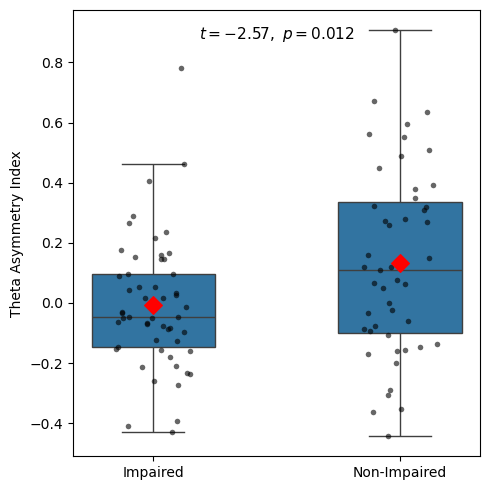

In [9]:
# Create group labels for plotting
df_plot = df.copy()
df_plot["group"] = df_plot["impaired"].map({
    True: "Impaired",
    False: "Non-Impaired"
})
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

order = ["Impaired", "Non-Impaired"]

plt.figure(figsize=(5, 5))

# Boxplot (no fliers = cleaner)
sns.boxplot(
    data=df_plot,
    x="group",
    y="theta_asymmetry_idx",
    order=order,
    showfliers=False,
    width=0.5
)

# Individual points
sns.stripplot(
    data=df_plot,
    x="group",
    y="theta_asymmetry_idx",
    order=order,
    color="black",
    alpha=0.6,
    jitter=0.15,
    size=4
)

# Mean markers
group_means = df_plot.groupby("group")["theta_asymmetry_idx"].mean()
for i, g in enumerate(order):
    plt.scatter(
        i,
        group_means[g],
        s=80,
        marker="D",
        color="red",
        zorder=5
    )

plt.xlabel("")
plt.ylabel("Theta Asymmetry Index")

plt.text(
    0.5,
    plt.ylim()[1] * 0.95,
    r"$t=-2.57,\ p=0.012$",
    ha="center",
    va="top",
    fontsize=11
)

plt.tight_layout()
plt.show()


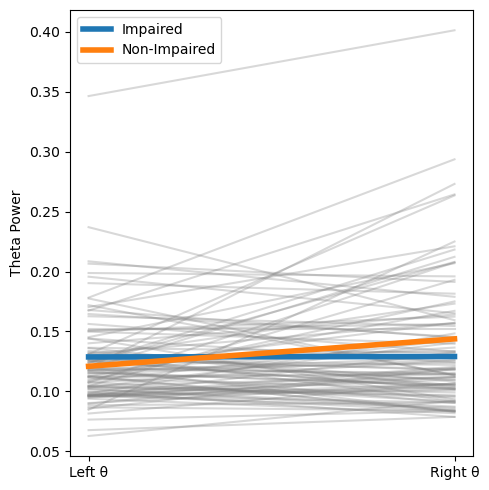

In [12]:
plt.figure(figsize=(5,5))

for _, row in df_plot.iterrows():
    x = [0, 1]
    y = [row["theta_ft_left"], row["theta_ft_right"]]
    plt.plot(x, y, color="gray", alpha=0.3)

# Group means
means = df_plot.groupby("group")[["theta_ft_left","theta_ft_right"]].mean()

for i, g in enumerate(order):
    plt.plot(
        [0, 1],
        means.loc[g],
        linewidth=4,
        label=g
    )

plt.xticks([0,1], ["Left θ", "Right θ"])
plt.ylabel("Theta Power")
plt.legend()
plt.tight_layout()
plt.show()
